In [1]:
import sys
import os 
sys.path.append('..')  #adds the Root Directory to the system path
from BL_CalciumAnalysis.image_analysis_methods import ImageAnalysis

In [2]:
from PIL import Image
import numpy as np
import os
import pandas as pd
from PIL import Image
import numpy as np
import cv2

In [ ]:
print(sys.executable) #print the path of the Python executable being used, which should point to the Python interpreter in your Conda environment.

In [56]:

from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage import io
import glob
import ast 


class ImageAnalysis:
    def __init__(self, project_folder):
        self.project_folder = project_folder
        self.directory_df = self.initialize_directory_df() 
        
    def initialize_directory_df(self):
        directories = [d for d in os.listdir(self.project_folder) if os.path.isdir(os.path.join(self.project_folder, d))]
        directory_data = [{'directory_name': d, 'directory_path': os.path.join(self.project_folder, d)} for d in directories]
        return pd.DataFrame(directory_data, columns=['directory_name', 'directory_path'])
    
    def list_directories(self):
        return [d for d in os.listdir(self.project_folder) if os.path.isdir(os.path.join(self.project_folder, d))]
    
    def list_files(self, folder_name):
        folder_path = os.path.join(self.project_folder, folder_name)
        all_files = []
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                all_files.append(os.path.join(root, file))
        return all_files
    
    def generate_dark_image(self, tiff_path, num_frames=200):
        """
        Generates a median 'dark' image from the first specified number of frames in a multi-frame TIFF file.

        This method is used for compensating the dark pixel offset in bioluminescence imaging data.

        Parameters:
        tiff_path (str): Path to the multi-frame TIFF file.
        num_frames (int, optional): Number of frames to consider for generating the dark image. Defaults to 200.

        Returns:
        numpy.ndarray: A median image representing the 'dark' image.
        """
        with Image.open(tiff_path) as img:
            frames = [np.array(img.getdata(), dtype=np.float32).reshape(img.size[::-1]) for i in range(num_frames)]
            median_frame = np.median(frames, axis=0)
            return median_frame

    def subtract_dark_image(self, raw_tiff_path, dark_image):
        """
        Subtracts a 'dark' image from each frame of a multi-frame TIFF file.

        This method is used to compensate for the average dark pixel offset in bioluminescence imaging data.

        Parameters:
        raw_tiff_path (str): Path to the raw multi-frame TIFF file.
        dark_image (numpy.ndarray): The 'dark' image to be subtracted from each frame of the raw image.

        Returns:
        list of numpy.ndarray: A list of images, each representing a frame from the raw image with the dark image subtracted.
        """
        with Image.open(raw_tiff_path) as img:
            compensated_images = []
            for i in range(img.n_frames):
                img.seek(i)
                frame = np.array(img.getdata(), dtype=np.float32).reshape(img.size[::-1])
                compensated_image = cv2.subtract(frame, dark_image)
                compensated_images.append(compensated_image)
            return compensated_images
        
    def expand_directory_df(self):
        # Add new columns with default empty lists
        self.directory_df['sensor_type'] = ''
        self.directory_df['session_id'] = ''
        self.directory_df['stimulation_ids'] = [[] for _ in range(len(self.directory_df))]
        self.directory_df['stimulation_frame_number'] = [[] for _ in range(len(self.directory_df))]

        for index, row in self.directory_df.iterrows():
            folder_name = row['directory_name']
            folder_path = row['directory_path']
            
            # Parse folder name for sensor type and session id
            parts = folder_name.split('_')
            sensor_type = 'gcamp8' if parts[0].startswith('g') else 'cablam'
            session_id = parts[0][1:] + parts[1]  # Assuming the first part is always the experiment ID

            # Update DataFrame with sensor_type and session_id
            self.directory_df.at[index, 'sensor_type'] = sensor_type
            self.directory_df.at[index, 'session_id'] = session_id

            # Check for CSV file ending in 'biolumi' or 'fluor'
            csv_filename = [f for f in os.listdir(folder_path) if (f.endswith('biolumi.csv') or f.endswith('fluor.csv'))]
            if csv_filename:
                csv_file_path = os.path.join(folder_path, csv_filename[0])
                df_csv = pd.read_csv(csv_file_path, header=None)
                stimulation_ids = df_csv.iloc[1].dropna().tolist()
                stimulation_frame_number = df_csv.iloc[0].dropna().tolist()

                # Update DataFrame with stimulation information
                self.directory_df.at[index, 'stimulation_ids'] = stimulation_ids
                self.directory_df.at[index, 'stimulation_frame_number'] = stimulation_frame_number

        return self.directory_df
    
    def get_session_raw_data(self, session_id):
        # Check if the session_id is in the 'session_id' column of the directory_df
        if session_id in self.directory_df['session_id'].tolist():
            # Find the directory path for the given session_id
            directory_path = self.directory_df[self.directory_df['session_id'] == session_id]['directory_path'].values[0]
            
            # Search for the .tif file within that directory
            for file_name in os.listdir(directory_path):
                if file_name.endswith('.tif'):
                    return os.path.join(directory_path, file_name)

            # If no .tif file is found in the directory
            return f"No .tif file found in the directory for session {session_id}."
        else:
            # If the session_id is not present in the DataFrame
            return f"Session ID {session_id} is not present in the directory DataFrame."
        
    def max_projection_mean_values(self, tif_path):
        """
        Generates a maximum intensity projection based on the mean values of a multi-frame TIF file
        and saves it to a new subdirectory 'processed_data/processed_image_analysis_output'
        with a '_max_projection' suffix in the file name.

        Parameters:
        tif_path (str): Path to the multi-frame TIF file.

        Returns:
        str: Path to the saved maximum intensity projection image.
        """

        with Image.open(tif_path) as img:
            # Initialize a summing array with the shape of the first frame and float type for mean calculation
            sum_image = np.zeros((img.height, img.width), dtype=np.float32)

            # Sum up all frames
            for i in range(img.n_frames):
                img.seek(i)
                sum_image += np.array(img, dtype=np.float32)

            # Compute the mean image by dividing the sum by the number of frames
            mean_image = sum_image / img.n_frames
        
        # Define the new directory path
        processed_dir = os.path.join(os.path.dirname(tif_path), 'processed_data', 'processed_image_analysis_output')
        
        # Create the directory if it does not exist
        os.makedirs(processed_dir, exist_ok=True)
        
        # Create a new file path for the max projection image with the '_max_projection' suffix
        # The filename is extracted from tif_path and appended with '_max_projection.tif'
        file_name = os.path.basename(tif_path)
        max_proj_image_path = os.path.join(processed_dir, file_name.replace('.tif', '_max_projection.tif'))
       
        # Save the max projection image to the new file path
        Image.fromarray(mean_image).save(max_proj_image_path)

        # Return the path to the saved image
        return max_proj_image_path
    
    def analyze_all_sessions(self, function_to_apply):
        """
        Iterates over all session IDs in the directory DataFrame and applies the given function to each.

        Parameters:
        function_to_apply (callable): Function to be applied to each session. It should accept a session ID.

        Returns:
        dict: A dictionary with session_ids as keys and function return values as values.
        """
        results = {}
        for session_id in self.directory_df['session_id']:
            try:
                result = function_to_apply(session_id)
                results[session_id] = result
            except Exception as e:
                print(f"An error occurred while processing session {session_id}: {e}")
        return results
    
    def add_tiff_dimensions(self):
        """
        Analyzes the dimensions of TIF files in the directory DataFrame and adds this data as new columns.
        """
        # Ensure the DataFrame has the columns for dimensions; initialize them with None or appropriate defaults
        if 'x_dim' not in self.directory_df.columns:
            self.directory_df['x_dim'] = None
            self.directory_df['y_dim'] = None
            self.directory_df['z_dim_frames'] = None

        # Iterate over each session_id and update the dimensions
        for index, row in self.directory_df.iterrows():
            tif_path = self.get_session_raw_data(row['session_id'])
            if isinstance(tif_path, str) and tif_path.endswith('.tif'):
                try:
                    with Image.open(tif_path) as img:
                        self.directory_df.at[index, 'x_dim'] = img.width
                        self.directory_df.at[index, 'y_dim'] = img.height
                        # For z-dimension, count the frames
                        img.seek(0)  # Ensure the pointer is at the beginning
                        frames = 0
                        while True:
                            try:
                                img.seek(img.tell() + 1)
                                frames += 1
                            except EOFError:
                                break
                        self.directory_df.at[index, 'z_dim_frames'] = frames
                except Exception as e:
                    print(f"Could not process TIF dimensions for session {row['session_id']}: {e}")
    
    def analyze_roi(self, session_id):
        """
        Analyzes ROI of the 'labels_postexport.tif' file for a given session and saves two results:
        one with labels and another without labels.I t also saves the labeled image data as numpy array for future use.
        """
        
        # SETP 1: DEFINE PATHS
        # define the paths, including the directory where processed images will be saved (processed_dir) 
        # and the name of the TIF file that contains the ROI labels (consistent_file_name)
        processed_dir = 'processed_data/processed_image_analysis_output'
        consistent_file_name = 'labels_postexport.tif'
        output_suffix_with_labels = '_roi_analysis_with_labels.png'
        output_suffix_without_labels = '_roi_analysis_without_labels.png'

        # STEP 2: RETRIEVE SESSION DATA 
        # Retrieve the directory path from the DataFrame
        # looks up the session's directory path from a DataFrame (directory_df) using the provided session_id. 
        # If the session ID isn't found, it returns a message indicating no directory entry was found for that session.
        
        directory_entry = self.directory_df[self.directory_df['session_id'] == session_id]
        if directory_entry.empty:
            return f"No directory entry found for session {session_id}"

        # STEP 3: VERIFY AND LOAD THE ROI TIF FILE 
        # constructs the full path to the labels_postexport.tif file and checks if it exists. If it does, the file is opened and loaded. 
        # If the file is in RGB format, it's converted to grayscale using rgb2gray from skimage.color. 
        # This conversion is crucial for analyzing the image as a binary mask where non-white pixels are considered ROIs.
        directory_path = directory_entry['directory_path'].values[0]
        
        # Build the path to the postexport TIFF file
        tiff_file_path = os.path.join(directory_path, processed_dir, consistent_file_name)

        # Verify that the file exists
        if not os.path.exists(tiff_file_path):
            return f"File not found for session {session_id}"

        
        
        # STEP 4: CREATE AND SAVE THE BINARY MASK
        # k: The method then converts the grayscale image to a binary mask, identifying all non-white pixels as ROIs 
        # (pixels with value less than 1 after normalization are set to 1, and others to 0). 
        # This binary mask is labeled using label from skimage.measure, assigning a unique label to each connected component (ROI).
        
        # Load the image
        mask_image = Image.open(tiff_file_path)

        # Convert RGB image to grayscale if necessary
        if mask_image.mode == 'RGB':
            # Convert to grayscale using skimage's rgb2gray
            image_array = rgb2gray(np.array(mask_image))

        # Assuming that all non-white pixels are ROIs
        binary_mask = np.where(image_array < 1, 1, 0)  # Here, 1 corresponds to white in the normalized grayscale image

        # Label the regions
        labeled_image = label(binary_mask, connectivity=1)
        num_rois = np.max(labeled_image)
        
        # Save the labeled image data as a NumPy array file for future processing
        labeled_image_path = os.path.join(directory_path, processed_dir, f"{session_id}_labeled_image.npy")
        np.save(labeled_image_path, labeled_image)
        
        
        # STEP 5: SAVE THE UNLABELED ROI IMAGE 
        # Save Unlabeled ROI Image: The method saves a version of the labeled image without any annotations to a specified path (output_path_without_labels). 
        # This image is saved in the processed_image_analysis_output directory with a specific suffix to indicate it's the unlabeled version.
        
        # Save the image without labels
        output_path_without_labels = os.path.join(directory_path, processed_dir, session_id + output_suffix_without_labels)
        plt.imsave(output_path_without_labels, labeled_image, cmap='nipy_spectral')

        
        # STEP 6: ANALYZE AND SAVE LABELED ROI IMAGE 
        # Iterates through each detected region using regionprops, extracts the centroid, 
        # and annotates the image with the region's label. 
        # This annotated image is saved separately, indicating it includes ROI labels.
        
        # Analyze regions and save properties
        regions = regionprops(labeled_image)

        # Prepare to save the ROI analysis image with labels
        output_path_with_labels = os.path.join(directory_path, processed_dir, session_id + output_suffix_with_labels)
        
        fig, ax = plt.subplots()
        ax.imshow(labeled_image, cmap='nipy_spectral')
        ax.axis('off')

        # Annotate each ROI with its corresponding label (ID)
        for region in regions:
            # Get the coordinates of the centroid of the region
            y, x = region.centroid
            # Annotate the ROI ID at the centroid position
            ax.text(x, y, str(region.label), color='white', ha='center', va='center')

        plt.savefig(output_path_with_labels)
        plt.close()

        # Return the paths of the saved figures LABELED AND UNLABELED and number of ROIs
        return (output_path_with_labels, output_path_without_labels), num_rois
    
    def analyze_all_rois(self):
        """
        Applies ROI analysis to all sessions and saves the results.
        """
        results = {}
        for session_id in self.directory_df['session_id']:
            result = self.analyze_roi(session_id)
            results[session_id] = result
        return results
    
    def extract_calcium_signals(self, session_id):
        """
        Extracts calcium signals from time-series data using the saved labeled ROI mask
        and saves the results as a CSV file in the 'processed_image_analysis_output' directory.

        Parameters:
        session_id (str): Session ID for which to perform the analysis.

        Returns:
        str: Path to the saved CSV file containing calcium signal data.
        """
        processed_dir = 'processed_data/processed_image_analysis_output'
        calcium_csv_suffix = '_calcium_signals.csv'

        # Retrieve the directory path from the DataFrame
        directory_entry = self.directory_df[self.directory_df['session_id'] == session_id]
        if directory_entry.empty:
            return f"No directory entry found for session {session_id}"

        directory_path = directory_entry['directory_path'].values[0]

        # Path to the saved labeled image numpy file
        labeled_image_path = os.path.join(directory_path, processed_dir, session_id + '_labeled_image.npy')

        # Verify and load the labeled image numpy file
        if not os.path.exists(labeled_image_path):
            return f"Labeled image file not found for session {session_id}"
        labeled_image = np.load(labeled_image_path)

        # Locate and load the time-series TIFF file
        tif_files = glob.glob(os.path.join(directory_path, '*.tif'))
        tif_files = [f for f in tif_files if 'postexport' not in f and 'labels' not in f]  # Ensure it's the correct TIFF
        if not tif_files:
            return f"No time-series .tif file found in the directory for session {session_id}"
        time_series_path = tif_files[0]  # Assuming there's only one relevant TIFF file
        time_series = io.imread(time_series_path)

        # Initialize an array to store calcium signal data
        num_rois = np.max(labeled_image)
        num_frames = time_series.shape[0]
        calcium_signals = np.zeros((num_rois, num_frames))

        # Extract the signal from each ROI in each frame
        for t in range(num_frames):
            frame = time_series[t]
            for roi in range(1, num_rois + 1):
                roi_mask = labeled_image == roi
                roi_data = frame[roi_mask]
                calcium_signals[roi - 1, t] = np.mean(roi_data)

        # Create and save the DataFrame with calcium signals
        calcium_df = pd.DataFrame(calcium_signals.T, columns=[f"ROI_{i}" for i in range(1, num_rois + 1)])
        calcium_df['Frame'] = np.arange(1, num_frames + 1)
        csv_path = os.path.join(directory_path, processed_dir, session_id + calcium_csv_suffix)
        calcium_df.to_csv(csv_path, index=False)

        return csv_path
    
    def analyze_all_calcium_signals(self):
        """
        Applies calcium signal extraction to all session_ids in the directory DataFrame and stores the results.
        """
        results = {}
        for session_id in self.directory_df['session_id']:
            # Ensure the ROI analysis has been done to get the labeled images
            roi_results = self.analyze_roi(session_id)
            # Check if analyze_roi returned a path to labeled images
            if isinstance(roi_results, tuple):
                # Extract calcium signals using the labeled ROI mask
                calcium_csv_path = self.extract_calcium_signals(session_id)
                results[session_id] = calcium_csv_path
            else:
                # If roi_results is an error message, pass it through
                results[session_id] = roi_results
        return results

    def plot_calcium_signals(self, session_id):
        processed_dir = 'processed_data/processed_image_analysis_output'
        calcium_csv_suffix = '_calcium_signals.csv'

        directory_entry = self.directory_df[self.directory_df['session_id'] == session_id]
        if directory_entry.empty:
            print(f"No directory entry found for session {session_id}")
            return

        directory_path = directory_entry['directory_path'].values[0]
        csv_path = os.path.join(directory_path, processed_dir, session_id + calcium_csv_suffix)

        if not os.path.exists(csv_path):
            print(f"Calcium signals file not found for session {session_id}")
            return

        calcium_signals_df = pd.read_csv(csv_path)
        frame_numbers = calcium_signals_df['Frame']
        calcium_signals = calcium_signals_df.drop('Frame', axis=1)

        # Normalize the signals and calculate offsets
        normalized_signals = (calcium_signals - calcium_signals.min()) / (calcium_signals.max() - calcium_signals.min())
        offsets = np.arange(len(normalized_signals.columns)) * 1.2  # Change 1.2 to the distance you want between plots

        plt.figure(figsize=(15, 10))
        
            # Access the stimulation timestamps for the session_id
        stim_frame_numbers = self.directory_df.loc[
            self.directory_df['session_id'] == session_id, 'stimulation_frame_number'
        ].values[0]

        # Add red dotted lines at the stimulation timestamps
        for frame_number in stim_frame_numbers:
            plt.axvline(x=frame_number, color='r', linestyle='--', linewidth=0.5)

        # Plot each normalized calcium signal with an offset
        for i, (roi_label, signal) in enumerate(normalized_signals.items()):
            plt.plot(frame_numbers, signal + offsets[i], label=roi_label)

        plt.xlabel('Frame Number')
        plt.ylabel('Normalized Calcium Signal (A.U.)')
        plt.title(f'Time Series of ROIs for Session {session_id}')

        # Set the y-axis ticks to the middle of the offset for each signal
        plt.yticks(ticks=offsets + 0.5, labels=normalized_signals.columns)
        
        plt.grid(False)
        plt.tight_layout()
        
        save_dir = os.path.join(directory_path, 'processed_data', 'processed_image_analysis_output')
        os.makedirs(save_dir, exist_ok=True)  # Create the directory if it does not exist
        save_path = os.path.join(save_dir, f"{session_id}_calcium_signals_plot.png")

        # Save the figure
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {save_path}")
        #remove the grid line from the background of the plot
        plt.show()

    def save_individual_roi_plots(self, session_id):
        processed_dir = 'processed_data/processed_image_analysis_output'
        cell_roi_dir = 'cell_roi_processed_data'
        calcium_csv_suffix = '_calcium_signals.csv'

        # Retrieve directory path and stimulation times from DataFrame
        directory_entry = self.directory_df[self.directory_df['session_id'] == session_id]
        if directory_entry.empty:
            print(f"No directory entry found for session {session_id}")
            return

        directory_path = directory_entry['directory_path'].values[0]
        stimulation_times = directory_entry['stimulation_frame_number'].values[0]  # Access stimulation times

        processed_data_path = os.path.join(directory_path, processed_dir)
        csv_path = os.path.join(processed_data_path, session_id + calcium_csv_suffix)
        roi_output_dir = os.path.join(processed_data_path, cell_roi_dir)
        
        # Make sure the output directory exists
        os.makedirs(roi_output_dir, exist_ok=True)

        # Verify that the calcium signals file exists
        if not os.path.exists(csv_path):
            print(f"Calcium signals file not found for session {session_id}")
            return

        # Read calcium signals into DataFrame
        calcium_signals_df = pd.read_csv(csv_path)
        frame_numbers = calcium_signals_df['Frame']
        calcium_signals = calcium_signals_df.drop('Frame', axis=1)

        # Plot and save each ROI signal
        for roi_label in calcium_signals:
            plt.figure(figsize=(10, 5))
            plt.plot(frame_numbers, calcium_signals[roi_label], label=roi_label)

            # Add red dotted lines at stimulation times
            for stim_time in stimulation_times:
                plt.axvline(x=stim_time, color='red', linestyle='--', linewidth=1)

            plt.title(f"ROI {roi_label} - Session {session_id}")
            plt.xlabel('Frame Number')
            plt.ylabel('Calcium Signal Intensity')
            plt.legend()
            plt.grid(True)

            # Save the plot
            save_path = os.path.join(roi_output_dir, f"{roi_label}_signal_plot.png")
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            plt.close()

            print(f"Plot for {roi_label} saved to {save_path}")
            
    def plot_roi_with_zoomed_stimulations(self, session_id):
        processed_dir = 'processed_data/processed_image_analysis_output'
        calcium_csv_suffix = '_calcium_signals.csv'

        # Retrieve directory path and stimulation frames from DataFrame
        directory_entry = self.directory_df[self.directory_df['session_id'] == session_id]
        if directory_entry.empty:
            print(f"No directory entry found for session {session_id}")
            return

        directory_path = directory_entry['directory_path'].values[0]
        csv_path = os.path.join(directory_path, processed_dir, session_id + calcium_csv_suffix)
        stimulation_frames = directory_entry['stimulation_frame_number'].iloc[0]  # Used directly as a list

        # Read the calcium signals
        calcium_signals_df = pd.read_csv(csv_path)
        frame_numbers = calcium_signals_df['Frame']
        calcium_signals = calcium_signals_df.drop('Frame', axis=1)
        
        # Determine the spacing factor based on the max calcium signal value
        spacing_factor = calcium_signals.max().max() * 0.1  # For example, 10% of the max signal
        
        # Number of subplots based on the number of stimulations
        num_stimulations = len(stimulation_frames)
        num_rois = calcium_signals.shape[1]

        # Create the figure with multiple subplots
        fig, axs = plt.subplots(num_stimulations + 1, 1, figsize=(15, 5 * (num_stimulations + 1)), gridspec_kw={'height_ratios': [3] + [1]*num_stimulations})
        
        # Plot the full session signal in the first subplot
        for i, col in enumerate(calcium_signals.columns):
            axs[0].plot(frame_numbers, calcium_signals[col] + (i * spacing_factor), label=col)

        # Add stimulation markers to the full session plot
        for stim_frame in stimulation_frames:
            axs[0].axvline(x=stim_frame, color='red', linestyle='--', linewidth=1)

        # Zoom into each stimulation event in the subsequent subplots
        for i, stim_frame in enumerate(stimulation_frames, start=1):
            start_frame = max(stim_frame - 100, 0)
            end_frame = min(stim_frame + 200, len(frame_numbers))
            for j, col in enumerate(calcium_signals.columns):
                signal_segment = calcium_signals[col][start_frame:end_frame]
                frame_segment = frame_numbers[start_frame:end_frame]
                axs[i].plot(frame_segment, signal_segment + (j * spacing_factor), label=col)

            # Add a vertical line for the stimulation moment
            axs[i].axvline(x=stim_frame, color='red', linestyle='--', linewidth=1)
            axs[i].set_xlim([start_frame, end_frame])

        # Adjust the layout and save the figure
        plt.tight_layout()
        plt.show()
        save_path = os.path.join(directory_path, processed_dir, f"{session_id}_detailed_ROI_analysis.png")
        fig.savefig(save_path, dpi=300)
        plt.close(fig)

        print(f"Detailed ROI analysis figure saved to {save_path}")
        
    def plot_and_save_roi_stimulations(self, session_id):
        processed_dir = 'processed_data/processed_image_analysis_output'
        calcium_csv_suffix = '_calcium_signals.csv'

        # Retrieve directory path from DataFrame
        directory_entry = self.directory_df[self.directory_df['session_id'] == session_id]
        if directory_entry.empty:
            print(f"No directory entry found for session {session_id}")
            return

        directory_path = directory_entry['directory_path'].values[0]
        csv_path = os.path.join(directory_path, processed_dir, session_id + calcium_csv_suffix)

        if not os.path.exists(csv_path):
            print(f"Calcium signals file not found for session {session_id}")
            return

        # Read calcium signals into DataFrame
        calcium_signals_df = pd.read_csv(csv_path)
        frame_numbers = calcium_signals_df['Frame']
        calcium_signals = calcium_signals_df.drop('Frame', axis=1)

        # Hardcoded stimulation frames
        stimulation_frames = [3587, 3788, 3990, 4191, 4393, 4595]

        # Ensure the output directory exists
        roi_output_dir = os.path.join(directory_path, processed_dir, 'cell_roi_processed_data')
        os.makedirs(roi_output_dir, exist_ok=True)

        for roi_label in calcium_signals:
            # Set up figure
            num_plots = len(stimulation_frames) + 1
            fig, axs = plt.subplots(num_plots, 1, figsize=(10, num_plots * 5))

            # Plot the full signal
            axs[0].plot(frame_numbers, calcium_signals[roi_label])
            axs[0].set_title(f"Full Session Calcium Signal for ROI {roi_label}")
            for stim_frame in stimulation_frames:
                axs[0].axvline(x=stim_frame, color='red', linestyle='--', linewidth=0.5)
            
            # Plot zoomed-in stimulations
            for idx, stim_frame in enumerate(stimulation_frames):
                zoom_start = max(stim_frame - 100, 0)
                zoom_end = min(stim_frame + 200, max(frame_numbers))
                zoomed_signal = calcium_signals[roi_label][zoom_start:zoom_end]
                zoomed_frame_numbers = frame_numbers[zoom_start:zoom_end]

                axs[idx + 1].plot(zoomed_frame_numbers, zoomed_signal)
                axs[idx + 1].axvline(x=stim_frame, color='red', linestyle='--', linewidth=0.5)
                axs[idx + 1].set_xlim(zoom_start, zoom_end)
                axs[idx + 1].set_title(f"Stimulation at Frame {stim_frame}")

            # Finalize and save figure
            plt.tight_layout()
            fig.savefig(os.path.join(roi_output_dir, f"{roi_label}_stimulation_plot.png"), dpi=300)
            plt.close()

            print(f"ROI {roi_label} plots saved in {roi_output_dir}")

In [57]:
#instantiates an ImageAnalysis object
project_folder = '/Volumes/MannySSD/cablam_imaging/raw_data_for_analysis' #path to the folder containing the raw data to be analyzed (i.e. the folder containing the folders for each experiment)
analysis = ImageAnalysis(project_folder)


print(analysis.directory_df)
analysis.directory_df

#expand the directory dataframe with the new columns
analysis.expand_directory_df()

                      directory_name  \
0     g21_12072023_estim_10hz_na_blk   
1     g22_12072023_estim_10hz_na_blk   
2     g23_12072023_estim_10hz_na_blk   
3     g13_12092023_estim_10hz_na_blk   
4   c32_12092023_estim_10hz_1xfz_blk   
5   c31_12092023_estim_10hz_1xfz_blk   
6     g11_12092023_estim_10hz_na_blk   
7       c12_12242023_estim_10hz_1xfz   
8       c12_12232023_estim_10hz_1xfz   
9       c22_12232023_estim_10hz_1xfz   
10      c13_12232023_estim_10hz_1xfz   
11      c21_12232023_estim_10hz_1xfz   
12      c11_12242023_estim_10hz_1xfz   
13    g12_12092023_estim_10hz_na_blk   
14      c23_12232023_estim_10hz_1xfz   
15    g11_12072023_estim_10hz_na_blk   
16      c13_12242023_estim_10hz_1xfz   
17     c21_12242023_estim_10hz_05xfz   
18     c22_12242023_estim_10hz_05xfz   
19     c23_12242023_estim_10hz_05xfz   

                                       directory_path  
0   /Volumes/MannySSD/cablam_imaging/raw_data_for_...  
1   /Volumes/MannySSD/cablam_imaging/raw_data_f

,directory_name,directory_path,sensor_type,session_id,stimulation_ids,stimulation_frame_number
0,g21_12072023_estim_10hz_na_blk,/Volumes/MannySSD/cablam_imaging/raw_data_for_...,gcamp8,2112072023,"[60, 60, 60, 60, 60, 60, 60, 60, 60, 60]","[3589, 3791, 3992, 4194, 4396, 4597, 4799, 500..."
1,g22_12072023_estim_10hz_na_blk,/Volumes/MannySSD/cablam_imaging/raw_data_for_...,gcamp8,2212072023,"[60, 60, 60, 60, 60, 60, 60, 60, 60, 60]","[3570, 3772, 3974, 4175, 4377, 4579, 4780, 498..."
2,g23_12072023_estim_10hz_na_blk,/Volumes/MannySSD/cablam_imaging/raw_data_for_...,gcamp8,2312072023,"[60, 60, 60, 60, 60, 60, 60, 60, 60, 60]","[3582, 3784, 3986, 4187, 4389, 4590, 4792, 499..."
3,g13_12092023_estim_10hz_na_blk,/Volumes/MannySSD/cablam_imaging/raw_data_for_...,gcamp8,1312092023,"[12, 24, 36, 60, 120, 480]","[3599, 3800, 4001, 4203, 4404, 4607]"
4,c32_12092023_estim_10hz_1xfz_blk,/Volumes/MannySSD/cablam_imaging/raw_data_for_...,cablam,3212092023,"[12, 24, 36, 60, 120, 480]","[3570, 3771, 3973, 4174, 4375, 4578]"
5,c31_12092023_estim_10hz_1xfz_blk,/Volumes/MannySSD/cablam_imaging/raw_data_for_...,cablam,3112092023,"[12, 24, 36, 60, 120, 480]","[3588, 3789, 3991, 4192, 4394, 4596]"
6,g11_12092023_estim_10hz_na_blk,/Volumes/MannySSD/cablam_imaging/raw_data_for_...,gcamp8,1112092023,"[12, 24, 36, 60, 120, 480]","[3593, 3794, 3995, 4197, 4398, 4600]"
7,c12_12242023_estim_10hz_1xfz,/Volumes/MannySSD/cablam_imaging/raw_data_for_...,cablam,1212242023,"[12, 24, 36, 60, 120, 240, 480, 960, 1920]","[3589, 3991, 4393, 4796, 5198, 5602, 6006, 641..."
8,c12_12232023_estim_10hz_1xfz,/Volumes/MannySSD/cablam_imaging/raw_data_for_...,cablam,1212232023,"[12, 24, 36, 60, 120, 480]","[3587, 3788, 3990, 4191, 4393, 4595]"
9,c22_12232023_estim_10hz_1xfz,/Volumes/MannySSD/cablam_imaging/raw_data_for_...,cablam,2212232023,"[12, 24, 36, 60, 120, 240, 480, 960, 1920]","[3583, 3985, 4387, 4789, 5192, 5595, 6000, 640..."


In [ ]:
session_ids = analysis.directory_df['session_id']
print(session_ids)


In [ ]:
# Usage example with a given session_id, assuming the session_id is present in the directory DataFrame and has a .tif file
session_id = '1212232023'  # Replace with your actual session_id
raw_data_path = analysis.get_session_raw_data(session_id) #get the raw data path for the given session_id

# below is the code to generate the max projection image for the raw data at the raw_data_path 
if raw_data_path and not raw_data_path.startswith("No .tif file"): #if the raw data path was found and does not start with "No .tif file"
    max_proj_image = analysis.max_projection_mean_values(raw_data_path) #generate the max projection image 


In [ ]:
# Assuming you've already initialized your ImageAnalysis instance and populated directory_df:
analysis.add_tiff_dimensions()

# Now the directory_df has the dimensions for each TIFF file included
print(analysis.directory_df.head())  # Display the updated DataFrame to verify


In [ ]:
analysis.directory_df

In [ ]:
# run the analysis on all sessions in the directory_df

#define a wrapper function to apply the max_projection_mean_values method to all sessions
def analyze_session_max_projection(session_id):
    """
    Wrapper function to apply max_projection_mean_values to a session's TIF file.

    Parameters:
    session_id (str): The session ID for which the TIF file will be processed.

    Returns:
    str: Path to the processed max projection TIFF file.
    """
    # analysis is an instance of ImageAnalysis
    tif_path = analysis.get_session_raw_data(session_id)
    if isinstance(tif_path, str) and tif_path.endswith('.tif'):
        return analysis.max_projection_mean_values(tif_path)
    else:
        return f"No valid TIF file found for session {session_id}"# Apply max_projection_mean_values to all sessions

results = analysis.analyze_all_sessions(analyze_session_max_projection)

# Output the results
for session_id, result_path in results.items():
    if isinstance(result_path, str):
        print(f"Session ID {session_id}: Max projection image saved at {result_path}")
    else:
        print(f"Session ID {session_id}: {result_path}")

In [ ]:
# Analyze ROIs for all sessions
analysis.analyze_all_rois()

In [6]:
# extract the calcium signal for a given session_id

session_id = '1212232023'  # Replace with your actual session_id
calcium_signals_path = analysis.extract_calcium_signals(session_id)
print(f"Calcium signals saved at: {calcium_signals_path}")


Calcium signals saved at: /Volumes/MannySSD/cablam_imaging/raw_data_for_analysis/c12_12232023_estim_10hz_1xfz/processed_data/processed_image_analysis_output/1212232023_calcium_signals.csv


In [ ]:
#extract calcium signals for all sessions in the directory_df

all_results = analysis.analyze_all_calcium_signals()

for session_id, csv_path in all_results.items():
    if isinstance(csv_path, str):
        print(f"Session {session_id} - Calcium signals saved at: {csv_path}")
    else:
        print(f"Session {session_id} - Error: {csv_path}")

Plot saved to /Volumes/MannySSD/cablam_imaging/raw_data_for_analysis/c12_12232023_estim_10hz_1xfz/processed_data/processed_image_analysis_output/1212232023_calcium_signals_plot.png


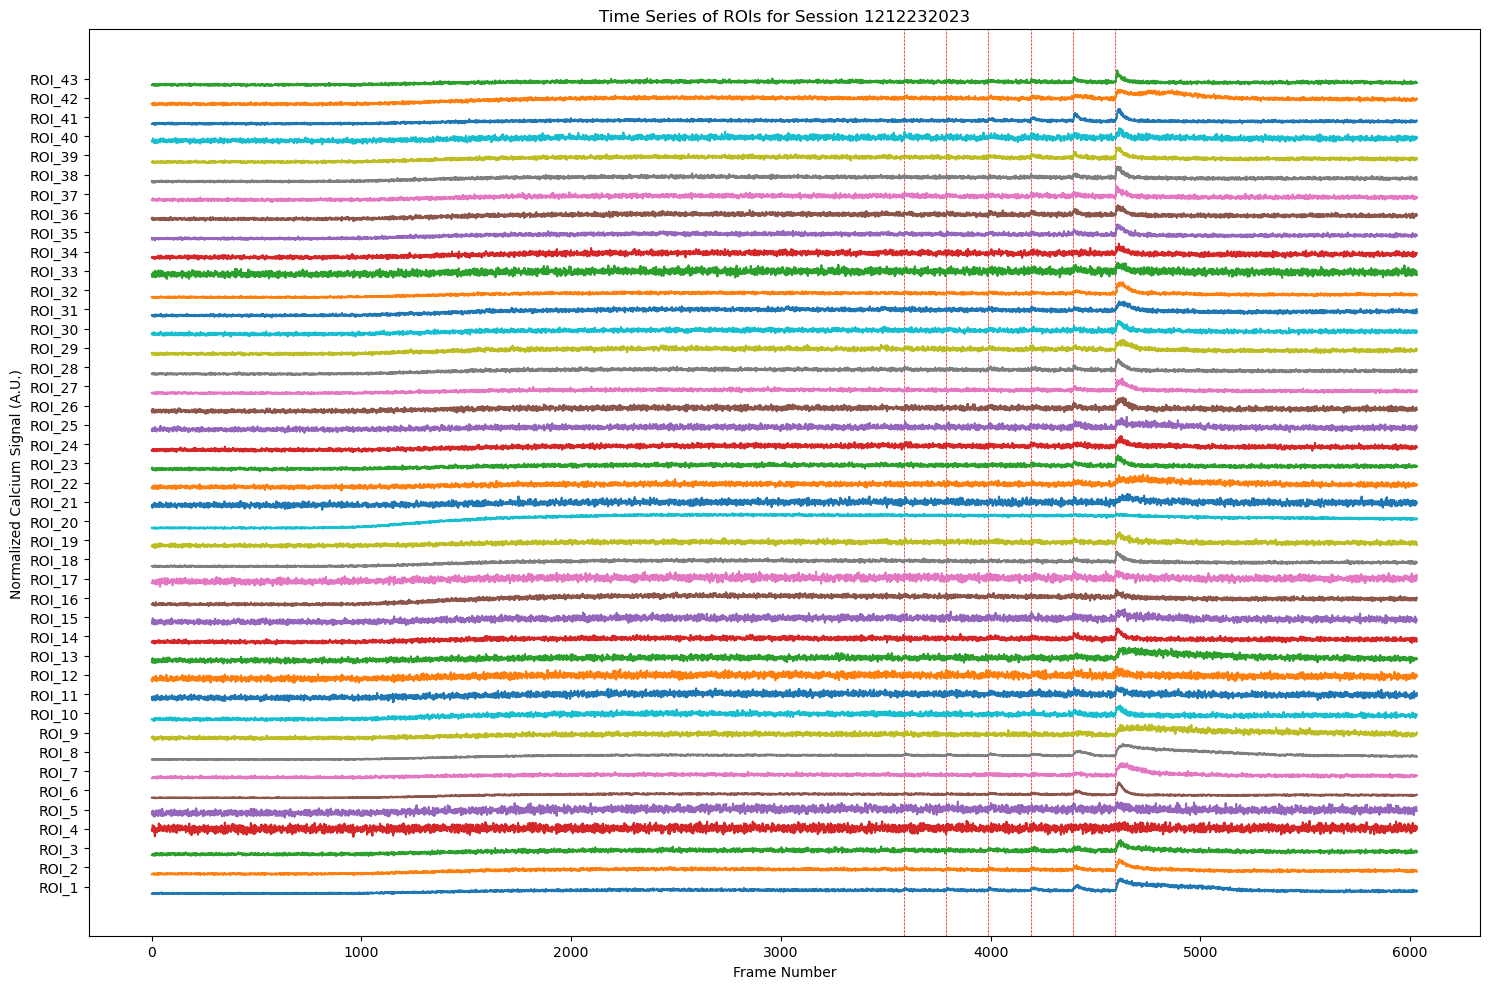

In [35]:
analysis.plot_calcium_signals(session_id)  # Replace with your actual session ID

In [43]:
analysis.save_individual_roi_plots(session_id)  # Replace with your actual session ID

Plot for ROI_1 saved to /Volumes/MannySSD/cablam_imaging/raw_data_for_analysis/c12_12232023_estim_10hz_1xfz/processed_data/processed_image_analysis_output/cell_roi_processed_data/ROI_1_signal_plot.png
Plot for ROI_2 saved to /Volumes/MannySSD/cablam_imaging/raw_data_for_analysis/c12_12232023_estim_10hz_1xfz/processed_data/processed_image_analysis_output/cell_roi_processed_data/ROI_2_signal_plot.png
Plot for ROI_3 saved to /Volumes/MannySSD/cablam_imaging/raw_data_for_analysis/c12_12232023_estim_10hz_1xfz/processed_data/processed_image_analysis_output/cell_roi_processed_data/ROI_3_signal_plot.png
Plot for ROI_4 saved to /Volumes/MannySSD/cablam_imaging/raw_data_for_analysis/c12_12232023_estim_10hz_1xfz/processed_data/processed_image_analysis_output/cell_roi_processed_data/ROI_4_signal_plot.png
Plot for ROI_5 saved to /Volumes/MannySSD/cablam_imaging/raw_data_for_analysis/c12_12232023_estim_10hz_1xfz/processed_data/processed_image_analysis_output/cell_roi_processed_data/ROI_5_signal_plot

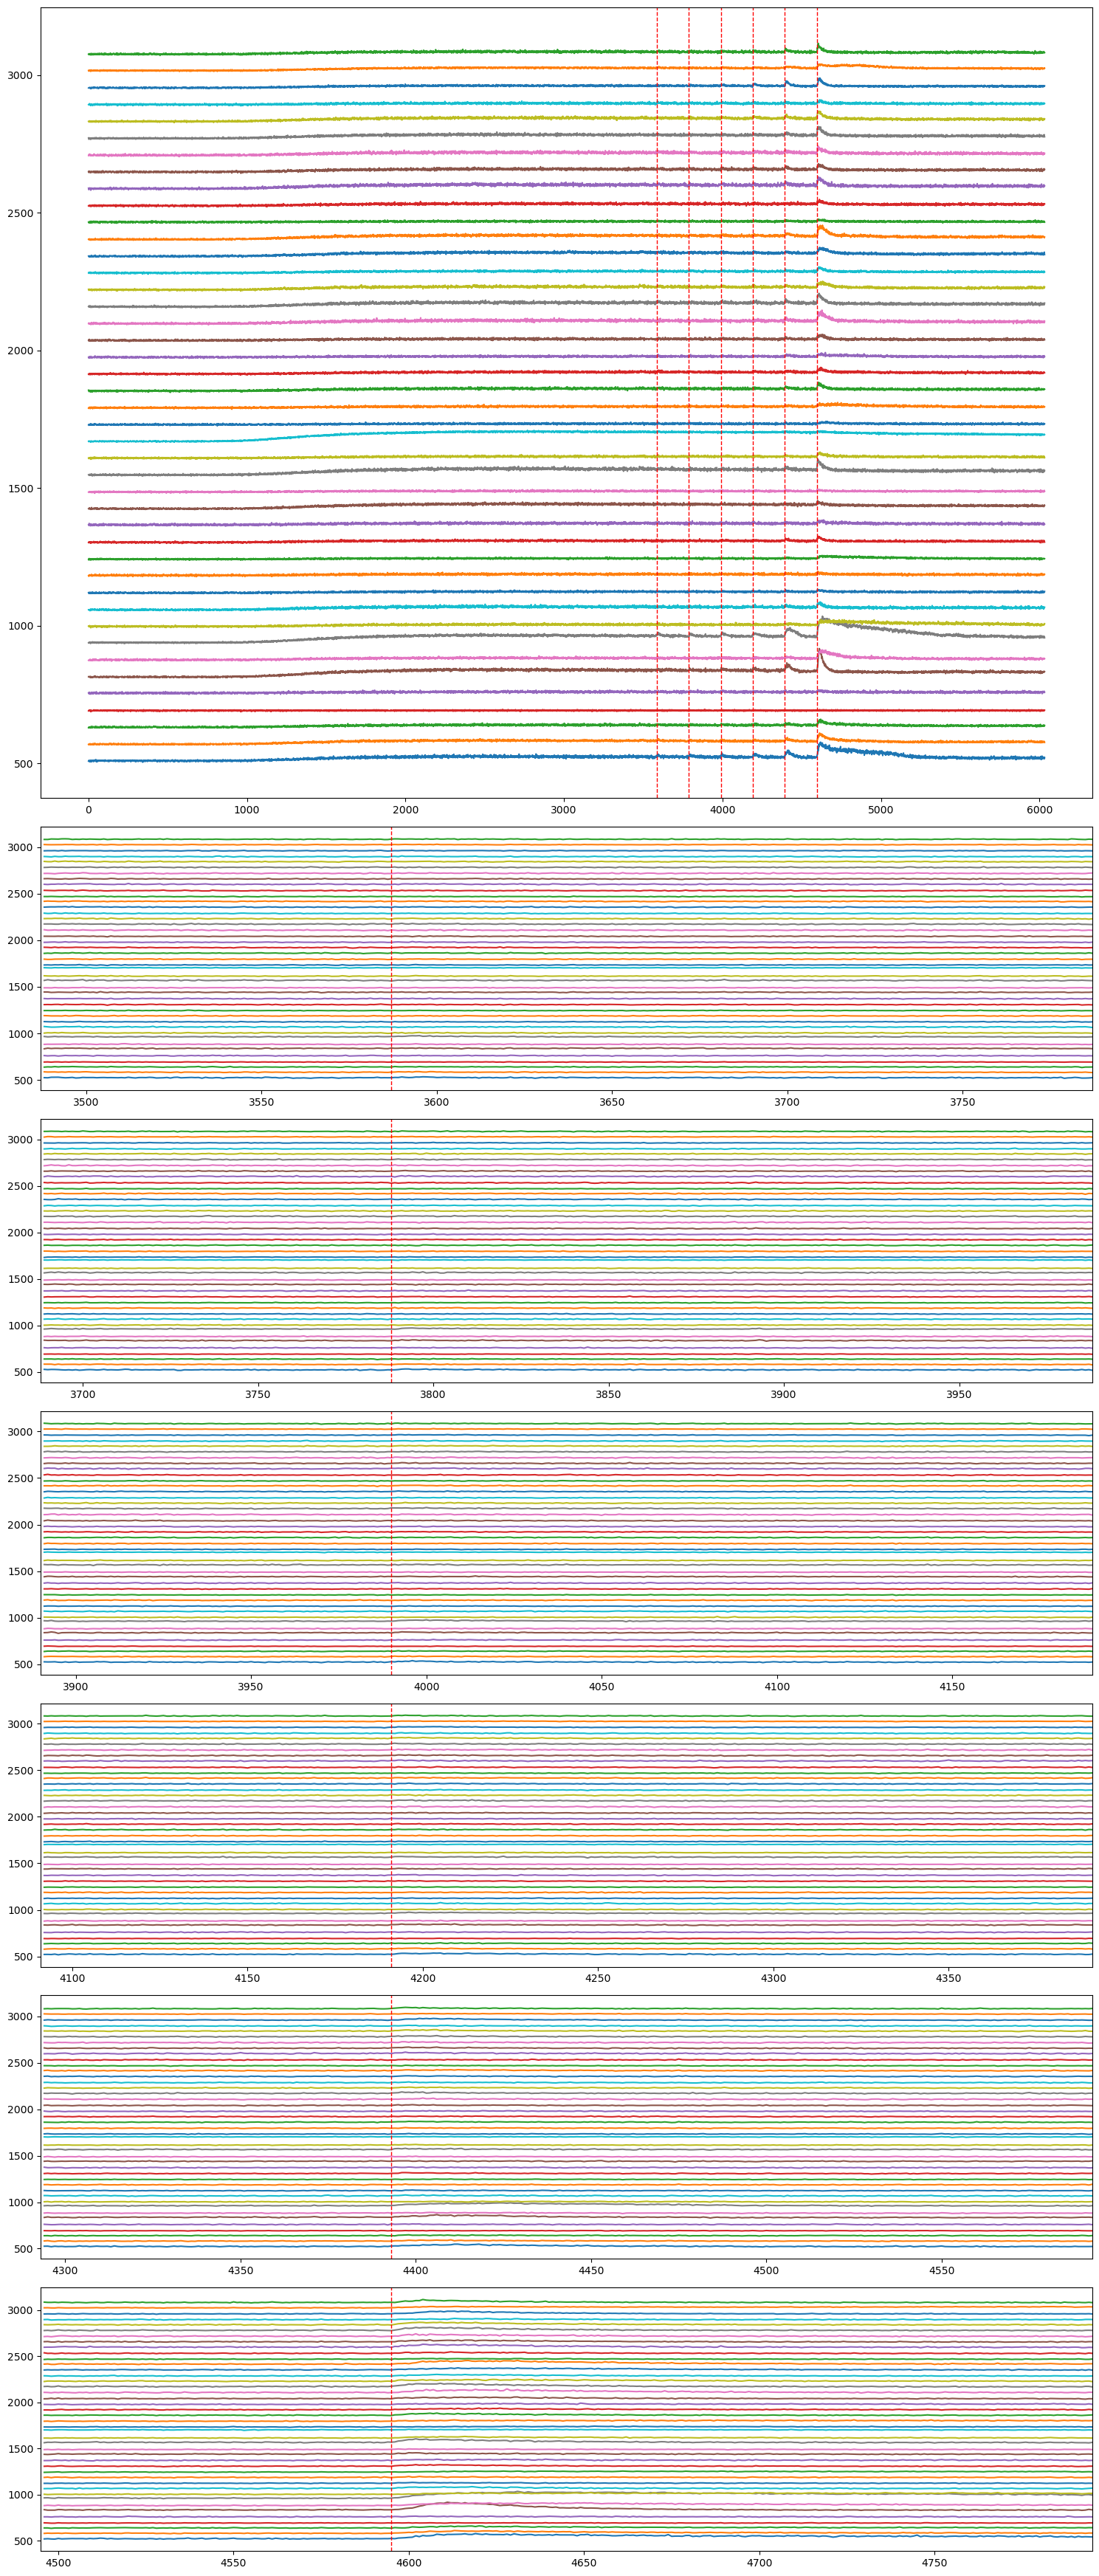

Detailed ROI analysis figure saved to /Volumes/MannySSD/cablam_imaging/raw_data_for_analysis/c12_12232023_estim_10hz_1xfz/processed_data/processed_image_analysis_output/1212232023_detailed_ROI_analysis.png


In [58]:
analysis.plot_roi_with_zoomed_stimulations(session_id)

In [59]:
analysis.plot_and_save_roi_stimulations(session_id)  # Replace with your actual session ID

ROI ROI_1 plots saved in /Volumes/MannySSD/cablam_imaging/raw_data_for_analysis/c12_12232023_estim_10hz_1xfz/processed_data/processed_image_analysis_output/cell_roi_processed_data
ROI ROI_2 plots saved in /Volumes/MannySSD/cablam_imaging/raw_data_for_analysis/c12_12232023_estim_10hz_1xfz/processed_data/processed_image_analysis_output/cell_roi_processed_data
ROI ROI_3 plots saved in /Volumes/MannySSD/cablam_imaging/raw_data_for_analysis/c12_12232023_estim_10hz_1xfz/processed_data/processed_image_analysis_output/cell_roi_processed_data
ROI ROI_4 plots saved in /Volumes/MannySSD/cablam_imaging/raw_data_for_analysis/c12_12232023_estim_10hz_1xfz/processed_data/processed_image_analysis_output/cell_roi_processed_data
ROI ROI_5 plots saved in /Volumes/MannySSD/cablam_imaging/raw_data_for_analysis/c12_12232023_estim_10hz_1xfz/processed_data/processed_image_analysis_output/cell_roi_processed_data
ROI ROI_6 plots saved in /Volumes/MannySSD/cablam_imaging/raw_data_for_analysis/c12_12232023_estim_1

In [ ]:
# Since the folders are directly inside the project_folder, you don't need to append any subdirectory name
data_files = analysis.list_files('') 
print(data_files) #print the list of files in the project folder 

directories = analysis.list_directories()
print(directories) #print the list of directories in the project folder

In [ ]:
# Assuming analysis is an instance of ImageAnalysis
first_row = analysis.directory_df.iloc[3]
directory_path = first_row['directory_path']

# Automatically generate file paths based on the directory path
dark_frames_path = os.path.join(directory_path, "dark_frames.tiff")
raw_image_path = os.path.join(directory_path, "raw_image.tiff")

print("dark_frames_path:", dark_frames_path)
print("raw_image_path:", raw_image_path)

tiff_path = '/Volumes/MannySSD/cablam_imaging/raw_data_for_analysis/c11_12232023_estim_10hz_1xfz/c11_12232023_estim_10hz_1xfz_biolumi_combined.tif'

# Generate the dark image
dark_image = analysis.generate_dark_image(tiff_path) #generates a dark image from the first 200 frames of the tiff file 

In [ ]:
import matplotlib.pyplot as plt
# Display the dark image
plt.imshow(dark_image, cmap='gray')
plt.axis('off')
plt.show()


In [ ]:
# Plot the calcium signals
plt.figure(figsize=(10, 6))
for roi in range(num_rois):
    plt.plot(calcium_signals[roi], label=f'ROI {roi + 1}')

plt.xlabel('Time (frames)')
plt.ylabel('Mean Intensity')
plt.title('Calcium Signals Over Time')
plt.legend()
plt.show()


In [ ]:

# Assuming 'tiff_path' contains the path to your time series TIFF file
# and 'labeled_image' is your ROI mask loaded as a numpy array
time_series = io.imread(tiff_path)  # This should be a 3D numpy array (time, y, x)
num_rois = np.max(labeled_image)
num_frames = time_series.shape[0]

# Initialize an array to hold the calcium signal data
calcium_signals = np.zeros((num_rois, num_frames))

# Process each frame to extract ROI signals
for t in range(num_frames):
    frame = time_series[t]
    for roi in range(1, num_rois + 1):  # ROIs are labeled from 1 to num_rois
        roi_mask = labeled_image == roi
        roi_data = frame[roi_mask]
        calcium_signals[roi - 1, t] = np.mean(roi_data) if roi_data.size > 0 else 0

# Plotting the calcium signals
offset = 10  # Change this value to adjust the vertical spacing between ROIs
plt.figure(figsize=(15, 8))
for roi in range(num_rois):
    plt.plot(calcium_signals[roi] + offset * roi, label=f'ROI {roi + 1}')  # Offset each ROI signal

plt.xlabel('Time')
plt.ylabel('ROI')
plt.title('Timeseries of ROIs')
#plt.yticks(ticks=np.arange(num_rois) * offset, labels=np.arange(1, num_rois + 1))  # Set y-ticks to show ROI IDs
plt.grid(True)
plt.show()


In [ ]:
# Load the time series TIFF file from the given path
time_series = io.imread(tiff_path)  # 3D numpy array: (time, y, x)
num_rois = np.max(labeled_image)    # Assuming labeled_image is already defined as shown before
num_frames = time_series.shape[0]

# Initialize an array to hold the calcium signal data for each ROI over time
calcium_signals = np.zeros((num_rois, num_frames))

# Process each frame to extract ROI signals
for t in range(num_frames):
    frame = time_series[t]
    for roi in range(1, num_rois + 1):  # ROI labels start from 1
        roi_mask = labeled_image == roi
        roi_data = frame[roi_mask]
        calcium_signals[roi - 1, t] = np.mean(roi_data) if np.any(roi_mask) else np.nan

# Plotting the calcium signals
plt.figure(figsize=(20, 10))  # Adjust the figure size as necessary

# Define vertical offset between lines to ensure clear separation
vertical_offset = 10  # Change as needed to match the plot scale and ROI separation

# Iterate over the ROIs to plot each one with an offset
for roi_idx in range(num_rois):
    plt.plot(calcium_signals[roi_idx] + (vertical_offset * roi_idx), label=f'ROI {roi_idx + 1}')

# Set the y-ticks to correspond to the ROIs
# Here, we create a list of y-tick positions based on the number of ROIs and the vertical offset
plt.yticks(ticks=np.arange(num_rois) * vertical_offset, labels=np.arange(1, num_rois + 1))

plt.xlabel('Time (frames)')
plt.ylabel('ROI')
plt.title('Timeseries of ROIs')
plt.grid(True)  # Include grid for better readability

# Optional: Adjust the limits of the y-axis if needed to fit your data range
plt.ylim(-5, (num_rois - 1) * vertical_offset + 15)

# Optional: If you want to show a legend mapping colors to ROI IDs
# plt.legend(loc='upper right')

plt.show()


In [ ]:
# Load and display the first few rows of the CSV file to understand its structure
file_path = '/mnt/data/c11_12232023_estim_10hz_1xfz_biolumi_combined_calcium_signals.csv'
calcium_data = pd.read_csv(file_path)

calcium_data.head()


# Load and display the first few rows of the second CSV file to understand its structure
stimulation_file_path = '/mnt/data/c11_12232023_estim_10hz_1xfz_biolumi.csv'
stimulation_data = pd.read_csv(stimulation_file_path)

stimulation_data.head()

# Re-load the data assuming there is no header and display it again to understand its structure
stimulation_data_no_header = pd.read_csv(stimulation_file_path, header=None)
stimulation_data_no_header.head()

In [ ]:
import math

# made modifications to the function to plot the calcium signals for each ROI with a white background and no grid lines and ensure 

def plot_roi_signals_no_grid(calcium_data, stimulation_frames, num_rois=46):
    # Determine the number of rows needed for the subplots (n)
    num_rows = math.ceil(num_rois / 5)

    # Extract the frame numbers for stimulations
    stimulation_points = stimulation_data_no_header.values.flatten()

    # Create the subplot grid and plot data with a white background and no grid lines
    fig, axs = plt.subplots(num_rows, 5, figsize=(25, 5 * num_rows), facecolor='white')
    for i in range(num_rois):
        row = i // 5
        col = i % 5
        # Generate a random color for each ROI
        random_color = np.random.rand(3,)
        axs[row, col].plot(calcium_data['Frame'], calcium_data[f'ROI_{i+1}'], label=f'ROI_{i+1}', color=random_color)
        # Add stimulation markers
        for stim_point in stimulation_points:
            axs[row, col].axvline(x=stim_point, color='red', linestyle='dotted')
        axs[row, col].set_title(f'ROI_{i+1}')
        axs[row, col].set_xlabel('Frame')
        axs[row, col].set_ylabel('Calcium Signal')
        axs[row, col].set_facecolor('white')
        axs[row, col].grid(False)  # Disable grid lines

    # Adjust the layout and display the plot
    plt.tight_layout()
    plt.show()

# Call the function to display the plot without grid lines
plot_roi_signals_no_grid(calcium_data, stimulation_data_no_header)


In [ ]:
def plot_all_rois_aligned(calcium_data, stimulation_frames, num_rois=46):
    # Extract the frame numbers for stimulations
    stimulation_points = stimulation_data_no_header.values.flatten()

    # Initialize the figure
    plt.figure(figsize=(20, 15))

    # Define y-ticks and their labels based on the number of ROIs
    y_ticks = []
    y_tick_labels = []

    # Calculate a reasonable fixed offset to visually separate the ROI lines
    fixed_offset = 100  # Adjust if necessary

    # Plot each ROI's calcium signal with a unique random color and apply fixed offset incrementally
    for i in range(num_rois):
        random_color = np.random.rand(3,)
        # Calculate the offset for this ROI's line
        offset = i * fixed_offset
        plt.plot(calcium_data['Frame'], calcium_data[f'ROI_{i+1}'] + offset, color=random_color, label=f'ROI_{i+1}')
        
        # Add y-tick at the median of the offset signal for the label
        y_ticks.append(np.median(calcium_data[f'ROI_{i+1}'] + offset))
        y_tick_labels.append(f'ROI_{i+1}')

    # Add stimulation markers
    for stim_point in stimulation_points:
        plt.axvline(x=stim_point, color='red', linestyle='dotted', linewidth=1)

    plt.xlabel('Frame')
    plt.ylabel('ROI')
    plt.yticks(y_ticks, y_tick_labels)
    plt.title('All ROIs Aligned with Corresponding Data')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Move the legend outside of the plot
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to make room for the legend
    plt.show()

# Call the function to display the plot with correctly aligned ROIs and their data
plot_all_rois_aligned(calcium_data, stimulation_data_no_header)


In [ ]:
def plot_roi_aligned_extended_frames(calcium_data, stimulation_frames, num_rois=46, frames_before_stim=1000):
    # Extract the frame numbers for stimulations and find the first stimulation frame
    stimulation_points = stimulation_frames.values.flatten()
    first_stim_frame = np.min(stimulation_points)

    # Set the range of frames to plot: from (first_stim_frame - frames_before_stim) to the end of the data
    start_frame = max(0, first_stim_frame - frames_before_stim)
    end_frame = calcium_data['Frame'].max()

    # Filter the calcium_data to include only the relevant frames
    limited_data = calcium_data[(calcium_data['Frame'] >= start_frame) & (calcium_data['Frame'] <= end_frame)]

    # Initialize the figure
    plt.figure(figsize=(20, 15))

    # Define y-ticks and their labels based on the number of ROIs
    y_ticks = []
    y_tick_labels = []

    fixed_offset = 100  # Adjust if necessary

    for i in range(num_rois):
        random_color = np.random.rand(3,)
        offset = i * fixed_offset
        plt.plot(limited_data['Frame'], limited_data[f'ROI_{i+1}'] + offset, color=random_color, label=f'ROI_{i+1}')
        
        y_ticks.append(np.median(limited_data[f'ROI_{i+1}'] + offset))
        y_tick_labels.append(f'ROI_{i+1}')

    # Add stimulation markers within the range
    for stim_point in stimulation_points:
        if start_frame <= stim_point <= end_frame:
            plt.axvline(x=stim_point, color='red', linestyle='dotted', linewidth=1)

    plt.xlabel('Frame')
    plt.ylabel('ROI')
    plt.yticks(y_ticks, y_tick_labels)
    plt.xlim(start_frame, end_frame)
    plt.title('Aligned ROIs with Extended Frame Range')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Move the legend outside of the plot
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to make room for the legend
    plt.show()

# Call the function with the extended frame range
plot_roi_aligned_extended_frames(calcium_data, stimulation_data_no_header)
